# CNN


In [ ]:
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes


%pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Block Structure in CNNs

A Block contains multiple convolutional layers, normalization layers, activation layers and often times skip connections.

Most modern CNNs contain 5 network layers, which are also called **_network stages_** to prevent confusion with convolutional layers.
Each network stage contains a variable number of blocks

### Kernel --> Filter --> Layer --> Block --> Stage --> Network

Each network stage reduces the height and width of the feature maps and
doubles the number of channels and contains multiple blocks.

If we want to increase the size of our model, we increase the number of blocks inside our network stages. We very rarely / never increase the number of network stages.

This means, that we mostly only use a single block and then stack it in the network stages as often as we want.

Let's look at one block: The residual block of the most famous CNN: ResNet

![](https://miro.medium.com/max/816/0*rj6SSHtBfBZXKSgC.png)


The weight layers are two convolutional layers. Betwen them we have a ReLU-activation function and a batch normalization (not displayed here). We also have a skip connection (also called residual connection or shortcut) that adds the input of the block on top of the output of the two convolutional layers.


There are lots of different ResNets

- resnet18,
- resnet34,
- resnet50,
- resnet101,
- resnet152,
- resnext50_32x4d,
- resnext101_32x8d,
- wide_resnet50_2,
- wide_resnet101_2,

We will look at ResNet18, ResNet34 and ResNet50


# Architecture of ResNet

![](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/resnet34.PNG)

![](https://pytorch.org/assets/images/resnet.png)


# Let's build a ResNet18

Stages 2-5 contain two residual blocks each.
But the second residual block reduces the resolution of the feature map but
double the number of channels


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        # In the init we decalare the attributes of the block (mostly layers)
        super().__init__()
        self.downsample = downsample

        if not downsample:
            # standard convolutional layer that keeps resolution constant
            self.conv1 = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                stride=1,
                bias=False,
            )
        else:
            # convolutional layer with stride 2. The output resolution of the feature map
            # has half the width and half the height of the input feature map
            self.conv1 = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                stride=2,
                bias=False,
            )

            # at the end of the residual block, we add the input to the output (skip connection)
            # but if we reduce the resolution of the output (with stride 2) the resolutions don't match
            # so we also have to reduce the resolution of the input
            # While reducing the resolution we also increase the number of channels
            # so we also use out_channels here to double the number of channels
            self.downsample_conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=2, bias=False
            )
            self.downsample_bn = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        # the forward method calculates the result of the block
        conv1_out = self.conv1(input)
        bn1_out = self.bn1(conv1_out)
        relu1_out = F.relu(bn1_out)

        conv2_out = self.conv2(relu1_out)
        bn2_out = self.bn2(conv2_out)

        if self.downsample == True:
            # half the width and height of input feature map if the block is downsampling
            # this also doubles the channel size
            input = self.downsample_conv(input)
            input = self.downsample_bn(input)

        # skip connection
        output = input + bn2_out
        return F.relu(output)


# create an example feature map with 64 channels and 56x56 resolutions
example_input = torch.zeros(1, 64, 56, 56)

# create a residual block, that takes 64 input channels, returns 64 output channels and doesn't reduce the resolution
res_block_without_downsample = ResidualBlock(
    in_channels=64, out_channels=64, downsample=False
)

# feed our example input through the residul block
output_no_downsample = res_block_without_downsample(example_input)
print(
    f"No downsampling: For input tensor with shape shape {example_input.shape} our output has shape {output_no_downsample.shape}"
)

No downsampling: For input tensor with shape shape torch.Size([1, 64, 56, 56]) our output has shape torch.Size([1, 64, 56, 56])


The first block in each stage reduces height and width of the input by half.
It also doubles the channels of the input


In [ ]:
# take an input with 64 channels and ouptut feature map with 128 channels
res_block_with_downsample = ResidualBlock(64, 128, downsample=True)
output_downsample = res_block_with_downsample(example_input)
print(
    f"With downsampling: For input tensor with shape shape {example_input.shape} our output has shape {output_downsample.shape}"
)

With downsampling: For input tensor with shape shape torch.Size([1, 64, 56, 56]) our output has shape torch.Size([1, 128, 28, 28])


Network stages 2-5 contain only residual blocks.
Now lets look at the first stage


### Stage 1 (also called Stem)

Convolutional layer with kernel size 7\*7 and stride 2.
Then regular maxpool


In [ ]:
stem = nn.Sequential(
    # conv halfs width and height and creates 64 channel feature map
    nn.Conv2d(
        in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False
    ),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    # maxpool also halfs width and height, channels stay the same
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

# lets try it out
example_input_image = torch.zeros(1, 3, 224, 224)

print(
    f"if we give an input with shape {example_input_image.shape} then the stem returns an output with shape {stem(example_input_image).shape}"
)

if we give an input with shape torch.Size([1, 3, 224, 224]) then the stem returns an output with shape torch.Size([1, 64, 56, 56])


### Classification Layer

Takes the last feature map as input. Then calculates the average for each channel.
Then uses one fully connected layer where the number of predicted classes is the number of neurons.


In [ ]:
# adaptive avg pool calculates the average for each channel
# if we have feature maps with 7x7 resolution and 512 channels
# we get the average for each 7x7 map --> 512 output values.

# if we have feature maps with 25x25 resolution and 512 channels
# we get the average for each 25x25 map --> 512 output values.

# --> Convolutional Layer don't care about the input resolution but
# Fully Connected layers do. With adaptive average pool we can input every
# resolution because the fully connected layer always gets 512 input values.
# --> CNN works for multiple different resolutions

example_feature_map1 = torch.zeros(1, 512, 7, 7)
example_feature_map2 = torch.zeros(1, 512, 25, 25)

adap_pool = nn.AdaptiveAvgPool2d(1)
print(
    f"first input has shape {example_feature_map1.shape} , second input has shape {example_feature_map2.shape}"
)
print("feed it throug adaptive average pool")
print(
    f"output of first feature map is shape {adap_pool(example_feature_map1).shape} and output of second feature is {adap_pool(example_feature_map2).shape}"
)


def get_classification_layer(channels):
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        # standard imagenet has 1000 classes
        nn.Linear(in_features=channels, out_features=1000),
    )

first input has shape torch.Size([1, 512, 7, 7]) , second input has shape torch.Size([1, 512, 25, 25])
feed it throug adaptive average pool
output of first feature map is shape torch.Size([1, 512, 1, 1]) and output of second feature is torch.Size([1, 512, 1, 1])


## Let's build the resnet

![](https://pytorch.org/assets/images/resnet.png)

Compare ResNet18 with ResNet34.
Only the number of residual blocks in the network stages is different.


In [ ]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.stage1 = stem
        self.stage2 = nn.Sequential(
            ResidualBlock(64, 64, downsample=False),
            ResidualBlock(64, 64, downsample=False),
        )

        self.stage3 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128, downsample=False),
        )

        self.stage4 = nn.Sequential(
            ResidualBlock(128, 256, downsample=True),
            ResidualBlock(256, 256, downsample=False),
        )

        self.stage5 = nn.Sequential(
            ResidualBlock(256, 512, downsample=True),
            ResidualBlock(512, 512, downsample=False),
        )

        self.classification_layer = get_classification_layer(512)

    def forward(self, input):
        stage1_output = self.stage1(input)
        stage2_output = self.stage2(stage1_output)
        stage3_output = self.stage3(stage2_output)
        stage4_output = self.stage4(stage3_output)
        stage5_output = self.stage5(stage4_output)
        classification = self.classification_layer(stage5_output)
        return classification


summary(ResNet18(), input_size=[1, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─ResidualBlock: 2-5                [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─Conv2d: 3-3                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 56, 56]           128
│    └─ResidualBlock: 2-6                [1, 64, 56, 56]           --
│

Ofcourse ResNet18 is also implemented in PyTorch


In [ ]:
summary(torchvision.models.resnet18())

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

If we want to create a ResNet34, we only need to increase the number of residual blocks for each network stage.
from [2,2,2,2] to [3,4,6,3]


In [ ]:
class ResNet34(nn.Module):
    def __init__(self):
        super().__init__()

        self.stage1 = stem

        self.stage2 = nn.Sequential(
            ResidualBlock(64, 64, downsample=False),
            ResidualBlock(64, 64, downsample=False),
            ResidualBlock(64, 64, downsample=False),
        )

        self.stage3 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128, downsample=False),
            ResidualBlock(128, 128, downsample=False),
            ResidualBlock(128, 128, downsample=False),
        )

        self.stage4 = nn.Sequential(
            ResidualBlock(128, 256, downsample=True),
            ResidualBlock(256, 256, downsample=False),
            ResidualBlock(256, 256, downsample=False),
            ResidualBlock(256, 256, downsample=False),
            ResidualBlock(256, 256, downsample=False),
            ResidualBlock(256, 256, downsample=False),
        )

        self.stage5 = nn.Sequential(
            ResidualBlock(256, 512, downsample=True),
            ResidualBlock(512, 512, downsample=False),
            ResidualBlock(512, 512, downsample=False),
        )

        self.classification_layer = get_classification_layer(512)

    def forward(self, input):
        stage1_output = self.stage1(input)
        stage2_output = self.stage2(stage1_output)
        stage3_output = self.stage3(stage2_output)
        stage4_output = self.stage4(stage3_output)
        stage5_output = self.stage5(stage4_output)
        classification = self.classification_layer(stage5_output)
        return classification


summary(ResNet34())
## identical to from pytorch torchvision.models.resnet34

Layer (type:depth-idx)                   Param #
ResNet34                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─ResidualBlock: 2-5                --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─Conv2d: 3-2                  36,864
│    │    └─BatchNorm2d: 3-3             128
│    │    └─BatchNorm2d: 3-4             128
│    └─ResidualBlock: 2-6                --
│    │    └─Conv2d: 3-5                  36,864
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─BatchNorm2d: 3-8             128
│    └─ResidualBlock: 2-7                --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─Conv2d: 3-10                 36,864
│    │    └─BatchNorm2d: 3-11          

## ResNet 50

ResNet50 is probably the most used CNN. But its residual block is different.
It is called a "bottleneck" block.

![](https://www.researchgate.net/profile/Kai-Heinrich-3/publication/337486420/figure/fig4/AS:829046489374720@1574671494601/Standard-Residual-vs-Bottleneck-Residual-Block-He-et-al-2015.ppm)


#### Why use a different block for deep Networks?

Training a neural net requires (GPU-)memory.
We need to store the following values:

- Each parameter (weight and bias of Conv/FC layer)
- The gradient of each parameter (after backpropagation)
  - If Adam is used, also the adaptive learnrate for each parameter
- All feature maps (including input image)


### Let's calculate the number of stored parameters in the fifth network stage of ResNet34

We have 3 residual blocks with 2 convolutional layers each.

Number of params in Convolutional Layer $= (w \times h \times c + 1) *numberFilter)$
(Careful: ResNet doesn't use bias because of BatchNorm )

- First residual block
  - First conv layer $= (3 \times 3 \times 256) \*512) =1,179,648 $
  - Second conv layer $= (3 \times 3 \times 512 + 1) *512) =2,359,296$
  - Skip conv layer $= (1 \times 1 \times 256) * 512) = 131,072$
  - Total $3,670,016$ params
- Second residual block
  - First conv layer $= (3 \times 3 \times 512 + 1) *512) =2,359,296$
  - Second conv layer $= (3 \times 3 \times 512 + 1) *512) =2,359,296$
  - Total $4,718,592$ params
- Third residual block
  - identical to second residual block

Total $=3,670,016 + 4,718,592 + 4,718,592 = 13,107,200$ parameter


In [ ]:
# BatchNorm stores for each channel of its input the  mean and standard deviation
# 512 channels --> 1024 parameters
summary(ResNet34().stage5)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─ResidualBlock: 1-1                     --
│    └─Conv2d: 2-1                       1,179,648
│    └─Conv2d: 2-2                       131,072
│    └─BatchNorm2d: 2-3                  1,024
│    └─Conv2d: 2-4                       2,359,296
│    └─BatchNorm2d: 2-5                  1,024
│    └─BatchNorm2d: 2-6                  1,024
├─ResidualBlock: 1-2                     --
│    └─Conv2d: 2-7                       2,359,296
│    └─Conv2d: 2-8                       2,359,296
│    └─BatchNorm2d: 2-9                  1,024
│    └─BatchNorm2d: 2-10                 1,024
├─ResidualBlock: 1-3                     --
│    └─Conv2d: 2-11                      2,359,296
│    └─Conv2d: 2-12                      2,359,296
│    └─BatchNorm2d: 2-13                 1,024
│    └─BatchNorm2d: 2-14                 1,024
Total params: 13,114,368
Trainable params: 13,114,368
Non-trainable params: 0

### Bottleneck Blocks

The number of parameters scales with number of input channels and number of output channels (filters).
If we increase the number of filters the number of parameters increases dramatically.

If we use $1\times1$ convolutions, instead of $3\times3$ convolutions, the number of needed parameters is only about ~$1/9$

We use this trick to reduce the number of channels for our $3\times3$ convolution but keep them high for $1\times1$ convolutions.

First we use one $1\times1$ convolutional filter to reduce the number of channels. Then we filter with $3\times3$ convolution
on the reduced number of channels. Then we increase the number of channels back again with $1\times1$ convolutions


Let's calculate the number of stored parameters in the fith network stage of ResNet50

- First bottleneck block

  - First conv layer $= (1 \times 1 \times 1024) \*512) =524,288 $

  - Second conv layer $= (3 \times 3 \times 512) \*512) =2,359,296 $

  - Third conv layer $= (1 \times 1 \times 512) \*2048) =1,048,576 $

  - Skip conv layer $= (1 \times 1 \times 1024) *2048) = 2,097,152$

  - Total $524,288+2,359,296+1,048,576+2,097,152= 6,029,312$ params

- Second bottleneck block

  - First conv layer $= (1 \times 1 \times 2048) \*512) =1,048,576 $

  - Second conv layer $= (3 \times 3 \times 512) \*512) =2,359,296 $

  - Third conv layer $= (1 \times 1 \times 512) \*2048) =1,048,576 $

  - Total $1,048,576 + 2,359,296 + 1,048,576 = 4,456,448$ params

- Third bottleneck block

  - identical to second bottleneck layer

Total $= 6,029,312 + 4,456,448 + 4,456,448 =14,942,208$


In [ ]:
# torch calls it "layer4" because they don't count the "stem" as layer
summary(torchvision.models.resnet50().layer4)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Bottleneck: 1-1                        --
│    └─Conv2d: 2-1                       524,288
│    └─BatchNorm2d: 2-2                  1,024
│    └─Conv2d: 2-3                       2,359,296
│    └─BatchNorm2d: 2-4                  1,024
│    └─Conv2d: 2-5                       1,048,576
│    └─BatchNorm2d: 2-6                  4,096
│    └─ReLU: 2-7                         --
│    └─Sequential: 2-8                   --
│    │    └─Conv2d: 3-1                  2,097,152
│    │    └─BatchNorm2d: 3-2             4,096
├─Bottleneck: 1-2                        --
│    └─Conv2d: 2-9                       1,048,576
│    └─BatchNorm2d: 2-10                 1,024
│    └─Conv2d: 2-11                      2,359,296
│    └─BatchNorm2d: 2-12                 1,024
│    └─Conv2d: 2-13                      1,048,576
│    └─BatchNorm2d: 2-14                 4,096
│    └─ReLU: 2-15                        --
├─B

It's higher than our ResNet34 which uses two $3 \times 3$ filter.
**But remember ResNet34 uses channelsize 512 while ResNet50 uses 2048**

### What would happen if we used the regular residual block instead of the bottleneck block and increased its channelsize to 2048?

The first block contain
$2,097,152 + 18,874,368 + 37,748,736 = 58.720.256$ params

And in its second and third block contain  
$ 37,748,736 + 37,748,736 = 75.497.472$ params

So this single stage would contain in total ~210 million parameters.

Bottleneck blocks allow us to increase numbers of channels while keeping numbers of parameters relatively small


In [ ]:
# Block that uses 2048 channels
summary(
    nn.Sequential(
        ResidualBlock(in_channels=1024, out_channels=2048, downsample=True),
        ResidualBlock(in_channels=2048, out_channels=2048, downsample=False),
        ResidualBlock(in_channels=2048, out_channels=2048, downsample=False),
    ),
)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─ResidualBlock: 1-1                     --
│    └─Conv2d: 2-1                       18,874,368
│    └─Conv2d: 2-2                       2,097,152
│    └─BatchNorm2d: 2-3                  4,096
│    └─Conv2d: 2-4                       37,748,736
│    └─BatchNorm2d: 2-5                  4,096
│    └─BatchNorm2d: 2-6                  4,096
├─ResidualBlock: 1-2                     --
│    └─Conv2d: 2-7                       37,748,736
│    └─Conv2d: 2-8                       37,748,736
│    └─BatchNorm2d: 2-9                  4,096
│    └─BatchNorm2d: 2-10                 4,096
├─ResidualBlock: 1-3                     --
│    └─Conv2d: 2-11                      37,748,736
│    └─Conv2d: 2-12                      37,748,736
│    └─BatchNorm2d: 2-13                 4,096
│    └─BatchNorm2d: 2-14                 4,096
Total params: 209,743,872
Trainable params: 209,743,872
Non-trainable params: 0

In [ ]:
class BottleNeckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()

        self.downsample = downsample
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(
            in_channels, out_channels // 4, kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels // 4)

        # decrease feature map resolution in second layer if we want to downsample with stride=2
        self.conv2 = nn.Conv2d(
            out_channels // 4,
            out_channels // 4,
            kernel_size=3,
            stride=2 if downsample else 1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels // 4)

        self.conv3 = nn.Conv2d(
            out_channels // 4, out_channels, kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels)

        if self.downsample or (in_channels != out_channels):
            self.skip_conv = nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=2 if self.downsample else 1,
                bias=False,
            )
            self.skip_bn = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        conv1_out = self.conv1(input)
        bn1_out = self.bn1(conv1_out)
        relu1_out = F.relu(bn1_out)

        conv2_out = self.conv2(relu1_out)
        bn2_out = self.bn2(conv2_out)
        relu2_out = F.relu(bn2_out)

        conv3_out = self.conv3(relu2_out)
        bn3_out = self.bn3(conv3_out)

        if self.downsample or (self.in_channels != self.out_channels):
            input = self.skip_conv(input)
            input = self.skip_bn(input)

        # skip connection
        output = input + bn3_out

        return F.relu(output)


ResNet50 is identical to ResNet34 but it uses BottleNeck blocks instead of Residual Blocks and increased channel size


In [ ]:
class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()

        self.stage1 = stem

        self.stage2 = nn.Sequential(
            BottleNeckBlock(64, 256, downsample=False),
            BottleNeckBlock(256, 256, downsample=False),
            BottleNeckBlock(256, 256, downsample=False),
        )

        self.stage3 = nn.Sequential(
            BottleNeckBlock(256, 512, downsample=True),
            BottleNeckBlock(512, 512, downsample=False),
            BottleNeckBlock(512, 512, downsample=False),
            BottleNeckBlock(512, 512, downsample=False),
        )

        self.stage4 = nn.Sequential(
            BottleNeckBlock(512, 1024, downsample=True),
            BottleNeckBlock(1024, 1024, downsample=False),
            BottleNeckBlock(1024, 1024, downsample=False),
            BottleNeckBlock(1024, 1024, downsample=False),
            BottleNeckBlock(1024, 1024, downsample=False),
            BottleNeckBlock(1024, 1024, downsample=False),
        )

        self.stage5 = nn.Sequential(
            BottleNeckBlock(1024, 2048, downsample=True),
            BottleNeckBlock(2048, 2048, downsample=False),
            BottleNeckBlock(2048, 2048, downsample=False),
        )

        self.classification_layer = get_classification_layer(2048)

    def forward(self, input):
        stage1_output = self.stage1(input)
        stage2_output = self.stage2(stage1_output)
        stage3_output = self.stage3(stage2_output)
        stage4_output = self.stage4(stage3_output)
        stage5_output = self.stage5(stage4_output)
        classification = self.classification_layer(stage5_output)
        return classification


summary(ResNet50())

Layer (type:depth-idx)                   Param #
ResNet50                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─BottleNeckBlock: 2-5              --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─Conv2d: 3-7                  16,384
│    │    └─BatchNorm2d: 3-8             512
│    └─BottleNeckBlock: 2-6              --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12          

Ofcourse ResNet50 is already included in PyTorch and we don't have to build it ourselves


In [ ]:
resnet50 = torchvision.models.resnet50()
summary(resnet50)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

#### [ConvNext](https://arxiv.org/pdf/2201.03545.pdf) (Released 22.03.2022)

Normal Convolution: $= (w \times h \times c + 1) *numberFilter)$

Depthwise Convolution: $= (w \times h \times 1 + 1) *numberFilter)$

(Filters only consider one channel of input instead of all channels. Saves parameters)

ConvNext is one of the best CNNs currently.
But it is pretty similar to a ResNet. It still contains 5 network stages but uses different blocks

![](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/convnext_architecture.png)


As Stem, ResNet uses a 7x7 strided conv layer and a maxpool.
ConvNext uses a 4x4 convolutional layer with stride 4 (so there is no overlap between the filters)


In [ ]:
convnext_stem = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=4, stride=4),
)

example_input_image = torch.zeros(1, 3, 224, 224)
print(
    f"the stem reduces height and width by four: input shape was  {example_input_image.shape}, output shape is {convnext_stem(example_input_image).shape}"
)

the stem reduces height and width by four: input shape was  torch.Size([1, 3, 224, 224]), output shape is torch.Size([1, 96, 56, 56])


In [ ]:
## full code here: https://github.com/pytorch/vision/blob/508bc1dc8d7cff5c1383068d6601ff669f69111d/torchvision/models/convnext.py#L38


class ConvNextBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.block = nn.Sequential(
            # depthwise convolution
            # each filter only looks at one channel, in contrast to normal convolution
            # massively reduces the number of params
            # depthwise (7x7+1)*C
            # normal (7x7xC+1)*C
            nn.Conv2d(
                in_channels=channels,
                out_channels=channels,
                kernel_size=7,
                padding=3,
                groups=channels,
            ),
            Permute([0, 2, 3, 1]),  # We need to implement Permute (not that important)
            nn.LayerNorm(channels),
            Permute([0, 3, 1, 2]),  # We need to implement Permute (not that important)
            nn.Conv2d(in_channels=channels, out_features=4 * channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(in_channels=4 * channels, out_channels=channels, kernel_size=1),
        )

    def forward(self, input):
        ## here it's a little more complicated, but not by much
        # result = layer_scale*self.block(input)
        # layer scale is a learned parameter of how much the skip connection should be weighted
        # initially it is a very small value, so that the network sticks to the identity function of the skip connection
        # it should then learn itself, which blocks are important

        # result = stochastic_depth(result)
        # similar to dropout. There is a certain chance, that a block is deactivated and only the input identity is returned
        # later blocks have a higher chance to be dropped

        # this here is the normal skip connection
        result = self.block(input)
        output = result + input
        return output

## Object Detection and Object Segmentation with CNNS


In [ ]:
## util functions


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.functional.to_pil_image(img)
        display(img)

## Object Detection

It's very computationally expensive to train an object detector so we use existing ones from PyTorch and take their trained weights.


The object detectors from PyTorch can detect the following classes


In [ ]:
CLASSES = [
    "__background__",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

color_palette = sns.color_palette("husl", len(CLASSES))

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [225, 211, 207,  ..., 225, 223, 216],
         [220, 229, 225,  ..., 224, 240, 234],
         [227, 235, 229,  ..., 220, 233, 223]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [212, 198, 194,  ..., 216, 214, 207],
         [207, 216, 212,  ..., 217, 233, 227],
         [214, 222, 216,  ..., 213, 226, 216]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [193, 179, 175,  ..., 207, 207, 200],
         [188, 197, 193,  ..., 207, 223, 217],
         [195, 203, 197,  ..., 203, 216, 206]]], dtype=torch.uint8)


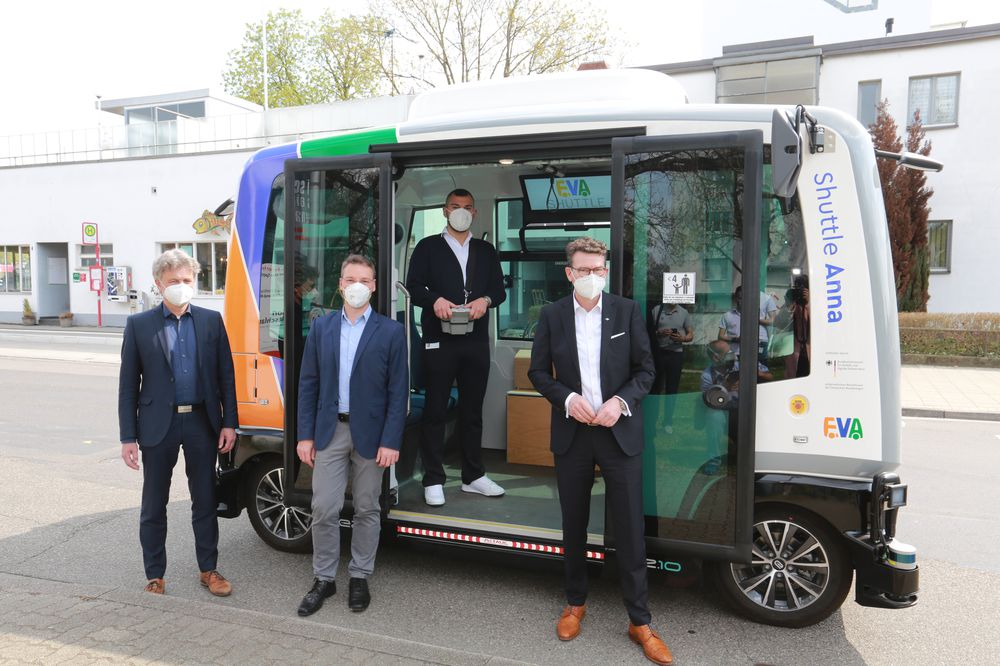

In [ ]:
import urllib


urllib.request.urlretrieve(
    "https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/eva.JPG", "eva.JPG"
)


orig_img = read_image("eva.JPG")
print(orig_img)

show(orig_img)

# create batch (with only one image)
scaled_img = (orig_img / 255).unsqueeze(dim=0)

#### Create our own Single-Stage Object Detector


First we need Anchor Boxes.
For this we save the width and height of all objects in our training dataset.
Then we create with k-means $k$ anchor boxes.

The following 8 anchor boxes were created from the nuScenes dataset, which contains 1,4 million annotated objects.

![](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/colored_anch_boxes.png)
![](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/shape_anchs.png)


In [ ]:
def get_anchors():
    # already calculated with kmeans from nuScenes
    return torch.tensor(
        [
            [15.58690644, 33.45222749],
            [38.85966844, 25.02378713],
            [245.40705481, 269.29423133],
            [129.14296132, 62.39221484],
            [202.20420614, 109.16240505],
            [34.61709156, 64.33043907],
            [69.99003352, 166.50778584],
            [76.74906765, 39.93999905],
        ],
    )


print(f"we have {len(get_anchors())} anchors \n {get_anchors()}")

we have 8 anchors 
 tensor([[ 15.5869,  33.4522],
        [ 38.8597,  25.0238],
        [245.4071, 269.2942],
        [129.1430,  62.3922],
        [202.2042, 109.1624],
        [ 34.6171,  64.3304],
        [ 69.9900, 166.5078],
        [ 76.7491,  39.9400]])


In [ ]:
class ObjectDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.anchors = get_anchors()
        self.resnet = ResNet50()

        # use all network stages from ResNet but remove the classification layer
        self.backbone = nn.Sequential(
            self.resnet.stage1,
            self.resnet.stage2,
            self.resnet.stage3,
            self.resnet.stage4,
            self.resnet.stage5,
        )

        # how many channels are needed for object detection
        prediction_channels = len(self.anchors) * (4 + len(CLASSES))

        # last feature map of ResNet has 2048 channels.
        self.detection_layer = nn.Conv2d(
            in_channels=2048, out_channels=prediction_channels, kernel_size=1
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.detection_layer(x)
        return x


my_OD = ObjectDetector()
example_input_image = torch.rand(1, 3, 224, 224).cuda()
object_detector_output = my_OD(example_input_image)
object_detector_output.shape

RuntimeError: ignored

For an input image with resolution $224 \times 224$ our backbone returns a feature map with $7\times7$ resolution.
Now, we have to convert this feature map into detection predictions.

Each pixel predicts $k$ bounding boxes (one for each anchor box).
A bounding box contains 4 values for it's position and size, and $num\_classes$ values for the class prediction of the box.

For $8$ anchor boxes and a final feature map resolution of $7\times7$ pixels we predict $7*7*8 = 392$ bounding boxes. It is very unlikely that our input image contains
this many objects, so most bounding boxes should be class "background".

Each pixel predicts $k * (4 + num\_classes)$ values --> so each pixel needs $k * (4 + num\_classes)$ channels to store these values

We use $8$ anchor boxes and have $91$ classes $8*(4+91) = 760$ channels

**Caution**: num_classes must contain the background class


![](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/anker_vis.PNG)

Our model predicts 760 values for each pixel.

For each anchor, it predicts $t_x, t_y, t_w, t_h$ and 91 classification values

From these model outputs we want to calculate the $x$, $y$, $w$ and $h$ of our bounding box

$x, y$ is the pixel position of the center of the bounding box

$x = (c_x + \sigma(t_x)) * 32$

$y = (c_y + \sigma(t_y)) * 32$

Our final feature map has a widht and height 32 times smaller than our input image ($224 \times 224$ --> $7 \times 7$)
This is caused by our 5 network stages that each reduce the width and height by half --> $5^2 = 32$

We want to place the boxes on top of the input image so we need to multipy the values of our final feature with the reduction factor
which is (always) 32

We use sigmoid to force a value between (0,1)
So the middle of the bounding box has to be inside the last feature map pixel.

for $t_x = -\infty $ we get $x = (c_x + 0)*32 = c_x*32$

for $t_x = \infty $ we get $x = (c_x + 1)\*32 $

for $t_x = 0 $ we get $x = (c_x + 1/2)*32$

lets say $c_x = 0$ so we are at the left most position.
For $-\infty$ we stay at 0, for $\infty$ the center of our bounding box is at pixel position 32

if we have $c_x = 6$ so we are at the most right position of our feature map. If our model predicts $\infty$ we get the position $6*32+32 = 224$ the most right position of our image

This is identical for $y$ and $t_y$


In [ ]:
def get_position(width, height):
    lin_x = torch.linspace(0, width - 1, width).repeat(height, 1).view(height * width)
    lin_y = (
        torch.linspace(0, height - 1, height)
        .repeat(width, 1)
        .t()
        .contiguous()
        .view(height * width)
    )
    return lin_x, lin_y


get_position(7, 7)

(tensor([0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3.,
         4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 0.,
         1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.,
         2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 5.,
         5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6.]))

For width and height of the bounding box we use the corresponding anchor box.

Each anchor box contains a width $p_w$ and height $p_h$
We use the exponential function to force a value between $(0, \infty)$

$w = p_w \* e^{t_w} $

$h = p_h \* e^{t_h} $

for $t_w = - \infty$ --> $w = 0$

for $t_w = \infty$ --> $w = \infty$

for $t_w = 0$ --> $w = p_w$

If model predicts $0$ we use the shape of the anchor box. Because the anchor boxes are generated from the training data, this is a good estimate.
So initially the model learns to always predict 0. Then it starts to deviate around 0 to make the bounding box better.


In [ ]:
def head(model_output):
    model_output = model_output.detach().clone()
    anchors = get_anchors()
    anchor_w = anchors[:, 0].contiguous().view(8, 1)
    anchor_h = anchors[:, 1].contiguous().view(8, 1)
    print("width of anchors ", anchor_w)
    print("height of anchors ", anchor_h)

    height = model_output.data.size(2)
    width = model_output.data.size(3)

    lin_x, lin_y = get_position(width, height)
    # split 760 channel into 8 anchor boxes and 95 bbox regressions/classifications
    # merge 7,7 pixels into one dimension into 49

    preds = model_output.detach().view(-1, len(anchors), 4 + 91, height * width)

    print("we reshaped our model output to ", preds.shape)
    # sigmoid output and add x position
    preds[:, :, 0, :].sigmoid_().add_(lin_x).mul_(32)
    # sigmoid output and add y postion
    preds[:, :, 1, :].sigmoid_().add_(lin_y).mul_(32)
    # use exponential function and multiply with anchor
    preds[:, :, 2, :].exp_().mul_(anchor_w)
    # use exponential function and multiply with anchor
    preds[:, :, 3, :].exp_().mul_(anchor_h)

    # use softmax for classification
    # the index with the highest value determines the class of the
    # bounding box
    preds[:, :, 4:96, :] = F.softmax(preds[:, :, 4:96, :], dim=1)

    return preds


m_output = head(object_detector_output)

print(
    f"leftmost center {torch.min(m_output[:, :, 0, :])} rightmost center {torch.max(m_output[:, :, 0, :])}"
)
print(
    f"thinnest bounding box: {torch.min(m_output[:, :, 2, :])}  widest bounding box {torch.max(m_output[:, :, 2, :])}"
)

NameError: ignored

### Possible Exercise in Exam?

You use a standard single-stage object detector that detects the classes dog and cat.
You use two anchor boxes with size (50,100) and (20,20).
You want to classify a 320\*320 RGB input image.

Questions:

1. What is the resolution of the final feature map of our object detector?
2. How many channels does our final feature map contain?


Answer:

1. We always use 32 as reduction factor --> 320 / 32 = 10x10 resolution
2. Formula is $k*(4+num\_classes)$ $k$ are our 2 anchor boxes. $num\_classes$ is $3$ (**DONT FORGET THE BACKGROUND CLASS**). $2*(4+3) = 24$ channels


#### Exercise 2

You use a standard single-stage object detector that detects the classes dog, cat and background in this order.

You use one anchor box with size (5,10).

You want to classify a 32\*32 RGB input image.

Your object detector returns the following seven values: $[0, \infty, 0, 1, 7, -2, 4]$

We use a threshold of $40\%$.

1. How many bounding boxes are predicted?
2. Where are they located?
3. What is their width and height?
4. What is the most likely class of the bounding box?
5. Do we visualize the box?


The seven values that the network predicts are $t_x, ~t_y, ~t_w, ~t_h, ~c_{dog}, ~c_{cat}, ~c_{background}$

Reminder $\sigma(x) = \frac{e^x}{1+e^x}$

##### 1.

We use only one anchor box and our output resolution is 1x1. $K*1*1 = 1$ We predict only 1 bounding box.

##### 2.

The formula is $x = (\sigma(t_x) + c_x) * 32$.

We calculate $\sigma(t_x) = 0.5$. $c_x = 0$ because we only have one pixel and we start counting at 0. $x= (0+0.5)*32 = 16$.

Equivalent for $y = (\sigma(\infty)+c_y)*32 = (1+0)*32 = 32$.

So our bounding box has its center at pixel position (16,32)

##### 3.

The formula is $w = p_w * e^{t_w}$

$p_w$ is 5 and $t_w$ is 0. with this we calculate $w= 5*e^0 = 5$

equivalent for $h.$
$~ p_h$ is 10 and $t_h$ is 1. With this we calculate $h = 10*e^1 = 27.18$

so our bounding box is 5 pixels wide and 27 pixels high

##### 4.

Just which position has the highest class besides the background position. 7 > 4 and 7 > -2. Because 7 is on the first position we predict a dog.

#### 5.

For this we calculate the softmax.

$p_{dog} = \frac{e^7}{e^7+e^{-2}+e^4} = 0.95$

$p_{cat} = \frac{e^{-2}}{e^7+e^{-2}+e^4} = 0.00$

$p_{background} = \frac{e^4}{e^7+e^{-2}+e^4} = 0.047$

$p_{dog}$ is greater than 0.4, so we visualize the bounding box

**Caution**: Imagine we get the values $[0.1, ~-2, ~0.2]$. Then background is the most likely class because 0.2 > 0.1 and 0.2 > -2.
But we still visualize the bounding box with the class dog.
$p_{dog} = \frac{e^{0.1}}{e^{0.1}+e^{-2}+e^{0.2}} = 0.45$ which is higher than the threshold.
So even if background is the most likely class it can happen, that we visualize the second highest class if its above the threshold.

But also the other way:
For values $[1.1, 1.0, 1.0]$ dog is the most likely, but we wouldn't visualize
the box because $p_{dog} = \frac{e^{1.1}}{e^{1.1}+e^{1}+e^{1}} = 0.36$ which is smaller than threshold.


### Use existing Object Detectors


#### RetinaNet (very similar to our custom object detector):

RetinaNet uses a ResNet50 as backbone and uses their own anchor boxes.
It was trained on the MS COCO Dataset.
It uses a Feature Pyramid Network ![FPN](https://production-media.paperswithcode.com/methods/new_teaser_TMZlD2J.jpg) which we won't cover here.

More object detectors can be found [here](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection)

(currently the best object detectors have box AP values of [63](https://paperswithcode.com/sota/object-detection-on-coco)) but they aren't available from PyTorch


In [ ]:
pretrained_weights = torchvision.models.detection.RetinaNet_ResNet50_FPN_Weights.DEFAULT
retinanet = torchvision.models.detection.retinanet_resnet50_fpn(
    weights=pretrained_weights
).cuda()

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 101MB/s]


In [ ]:
def predict(model, input_image):
    # takes an model and feeds it our input image

    # all object detectors expect the image to have values between [0,1]
    # a normal image has values between [0,255].
    # if this happens, we divide by 255 and create a batch with only this image

    if torch.max(input_image) > 1.0:
        # if input image had shape [3,224,224] it now has shape [1,3,224,224]
        input_image = (input_image / 255).unsqueeze(dim=0)

    # we don't want to train the model so set it to evaluation mode
    model.eval()

    # put our input image on the GPU and feed it through the network
    prediction = model(input_image.cuda())

    # we get a list for each image in our batch.
    # because we only have one image the list contains only one element.
    # We take it directly
    return prediction[0]


def scale_color(inp):
    # to get pretty colors
    return int(inp * 255) * 201231 % 255


def visualize(prediction, im, threshold, verbose=True):
    if verbose:
        # show the original image without bounding boxes
        show(im)

    # take all class predictions that are higher than the threshold
    class_predictions = prediction["labels"][prediction["scores"] > threshold]
    # get their corresponding names
    class_names = [CLASSES[i] for i in class_predictions]
    # get their corresponding bounding boxes
    boxes = prediction["boxes"][prediction["scores"] > threshold]
    # get color_coded classes
    colors = [(color_palette[i]) for i in class_predictions]
    colors = [tuple(map(scale_color, tup)) for tup in colors]

    # draw bounding box on top of original image with colored bounding box and class text
    bbox_img = draw_bounding_boxes(im, boxes, class_names, colors, width=5).cpu()
    if verbose:
        # show image with bounding boxes
        show(bbox_img)
    return bbox_img

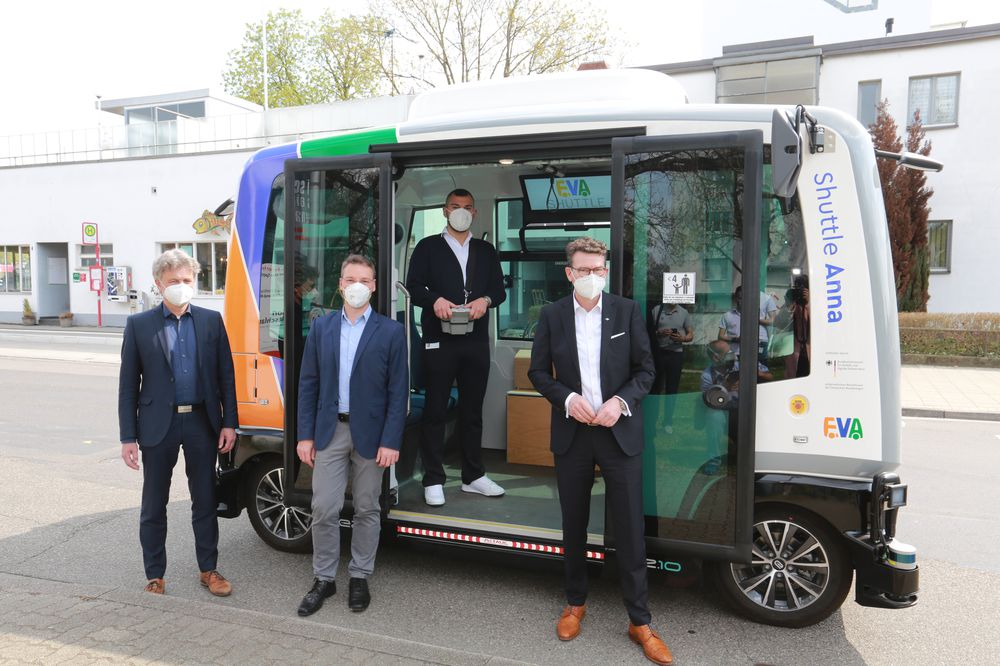

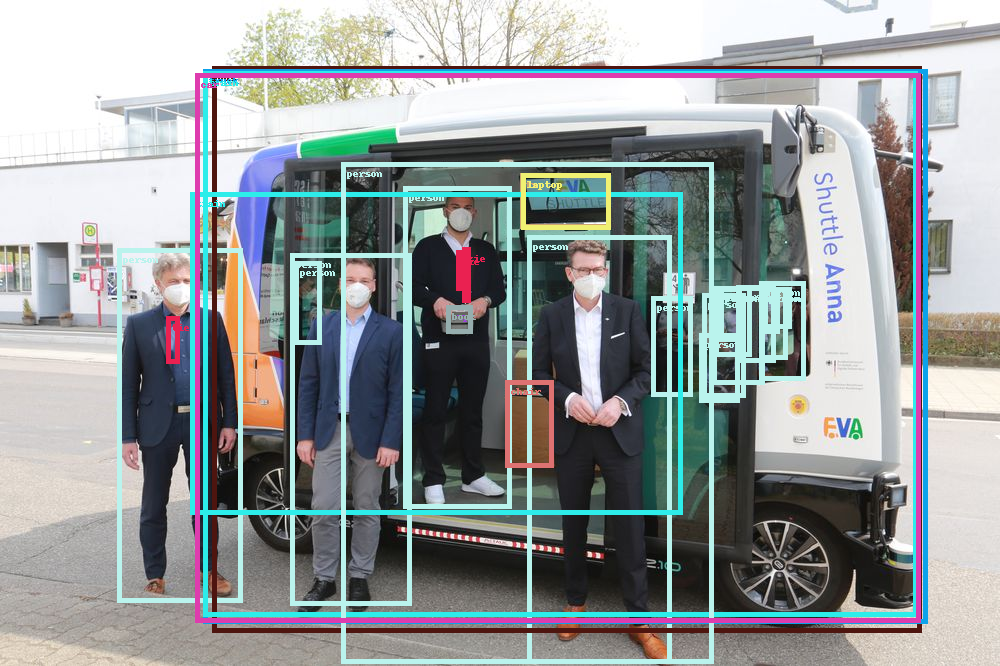

In [ ]:
threshold = 0.2
detection = predict(retinanet, orig_img)
bbox_img = visualize(detection, orig_img, threshold=threshold)


### Can we use this detector for autonomous driving?

Let's take some recorded images and use the RetinaNet


In [ ]:
# unzip for colab
!unzip nuScenes.zip

unzip:  cannot find or open nuScenes.zip, nuScenes.zip.zip or nuScenes.zip.ZIP.


In [ ]:
import glob

from PIL import Image


def nuScenesGIF():
    fp_in = "./nuScenes/*.jpg"
    fp_out = "./nuScenes.gif"
    # imgs = (Image.open(f).resize((854,480),Image.Resampling.LANCZOS) for f in sorted(glob.glob(fp_in))) for new PIL Versions
    imgs = (
        Image.open(f).resize((854, 480), Image.LANCZOS)
        for f in sorted(glob.glob(fp_in))
    )
    tensors = [read_image(f) for f in sorted(glob.glob(fp_in))]
    img = next(imgs)  # extract first image from iterator
    img.save(
        fp=fp_out, format="GIF", append_images=imgs, save_all=True, duration=100, loop=0
    )

    return tensors


input_tensors = nuScenesGIF()
print(f" we have {len(input_tensors)} images each with shape {input_tensors[0].shape}")

Now we want to create bounding boxes for this short video

![](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/nuScenes.gif)


In [ ]:
def create_bbox_gif(model, name):
    gif_imgs = []
    for i in input_tensors:
        detection = predict(model, i)
        bbox_img = visualize(detection, i, threshold=threshold, verbose=False)
        # pil_bbox_img = transforms.functional.to_pil_image(bbox_img).resize((480,360),Image.Resampling.LANCZOS)
        pil_bbox_img = transforms.functional.to_pil_image(bbox_img).resize(
            (480, 360), Image.LANCZOS
        )
        gif_imgs.append(pil_bbox_img)
    gif_imgs[0].save(
        fp=f"{name}_bbox.gif",
        format="GIF",
        append_images=gif_imgs[1:],
        save_all=True,
        duration=200,
        loop=0,
    )


create_bbox_gif(retinanet, "retina")

And let's also use a slightly stronger object detector FCOS


In [ ]:
fcos = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True).cuda()
create_bbox_gif(fcos, "fcos")

Retina on the left, FCOS to the right

![Retina](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/retina_bbox.gif) | ![FCOS](https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/fcos_bbox.gif)


Every prediction is done for every single image independently of all other images. We completely lose temporal information. E.g. we can't predict the speed of the objects.
Furthermore our detector only returns the pixel positions of the bounding boxes. For automotive driving, we need the real-world coordinates
with 3D Detections.

Usually we use https://github.com/open-mmlab/mmdetection3d for camera/lidar based 3D-Object Detection
